# Financial Risk Analysis Project - Andrey Augusto Barbosa

This project focus on the development of a Credit risk model for assessing the probability of default. 

Abstract:
This assignment was focused on the development of a credit risk model. Random Forest models and logistic regression models were evaluated as candidates. The developed routine comprised pre-processing methods (standarization - RobustScaling() and treatment of null values). The models'performance were evaluated by the ROC curve score through cross validation analysis combined with a grid parameter search. Results were aftwards "compared" with the available in Kaggle for this analysis. However, in Kaggle, a different test dataset was applied for competitors.

## The dataset

The dataset was provided and consists of 250,000 borrowers put together by Kaggle. You can read more about the dataset [here](https://www.kaggle.com/c/GiveMeSomeCredit/overview).

The dataset was initially provided as part of competition hosted by Kaggle called "Give me Some Credit" which is defined according to the website:
*Improve on the state of the art in credit scoring by predicting the probability that somebody will experience financial distress in the next two years.*

In this assignment, 150,000 borrowers was given as the initial dataset. This one is smaller than the original one considering that inconsistencies in the data was after found and removed.

* credit_risk_PD.csv: this is your data on the 150,000 borrowers. You'll need to split it into train/test sets. The dependent variable (outcome variable) is the column called **SeriousDlqin2yrs** which is 0 for no default in two years by a client and 1 in case of default.

In [1]:
#Importation of the relevant libraries specially scikit learn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer

In [2]:
#Import and split the data in train and test dataset
df_train = pd.read_csv('./credit_risk_PD_train.csv')
df_test = pd.read_csv('./credit_risk_PD_test.csv')

## Some Exploratory Data Analysis (EDA) is performed:

In [3]:
df_train.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,58066,0,1.000000,55,0,0.395662,13000.0,4,0,3,0,1.0
1,96345,0,0.423563,51,0,0.464923,12500.0,12,0,2,0,0.0
2,129144,0,0.005760,43,0,0.273804,6500.0,16,0,1,0,0.0
3,98955,0,0.142857,32,0,0.181927,2500.0,7,0,0,0,2.0
4,97606,0,0.049966,49,0,0.578977,3500.0,8,0,1,0,2.0


The initial data exploratory analysis above depicts that no classes exist, so, the there is no need to use dummy variables in this case.

In [4]:
#Analyzing the ones with SeriousDlqin2yrs equal to 0 (there was no serious default event in two years):
df_train[df_train['SeriousDlqin2yrs'] == 0].describe()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,112004.000000,112004.0,112004.000000,112004.000000,112004.000000,112004.000000,8.963500e+04,112004.000000,112004.000000,112004.000000,112004.000000,109037.000000
mean,75111.999643,0.0,6.136567,52.751027,0.279186,355.466149,6.771587e+03,8.495286,0.135861,1.020071,0.126522,0.743977
std,43288.035447,0.0,223.770387,14.792302,2.950968,2009.034872,1.608564e+04,5.097311,2.914870,1.101724,2.906263,1.105594
min,2.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,37665.750000,0.0,0.027080,42.000000,0.000000,0.173536,3.460000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,75172.500000,0.0,0.133264,52.000000,0.000000,0.362170,5.467000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,112589.250000,0.0,0.486444,63.000000,0.000000,0.862041,8.333000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,149999.000000,0.0,29110.000000,109.000000,98.000000,329664.000000,3.008750e+06,57.000000,98.000000,32.000000,98.000000,20.000000


In [5]:
#Analyzing the ones with SeriousDlqin2yrs equal to 1 (there was at least one serious default event in two years):
df_train[df_train['SeriousDlqin2yrs'] == 1].describe()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,7996.000000,7996.0,7996.000000,7996.000000,7996.000000,7996.000000,6632.000000,7996.00000,7996.000000,7996.000000,7996.000000,7854.000000
mean,75077.036893,1.0,3.625016,45.856803,2.448599,298.654127,5613.548402,7.84905,2.149075,0.984367,1.886193,0.935702
std,43519.458747,0.0,117.290678,12.977736,11.963107,1265.937269,6358.084972,5.65914,11.990502,1.428165,11.982907,1.218962
min,1.000000,1.0,0.000000,21.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,37535.250000,1.0,0.406635,36.000000,0.000000,0.192119,2961.500000,4.00000,0.000000,0.000000,0.000000,0.000000
50%,74096.000000,1.0,0.844608,45.000000,0.000000,0.429455,4500.000000,7.00000,0.000000,1.000000,0.000000,0.000000
75%,112894.250000,1.0,1.000000,54.000000,2.000000,0.906821,6750.000000,11.00000,1.000000,2.000000,1.000000,2.000000
max,149980.000000,1.0,8328.000000,101.000000,98.000000,38793.000000,250000.000000,57.00000,98.000000,29.000000,98.000000,8.000000


**Conclusions**: Dataset looks promising in a certain way. Main parameters for customers with a serious Delinquency in two years is compared to others with no delinquency by their mean values below. Bold lines depict parameters who showed relevant differences:<br>

**SeriousDlqin2yrs : 0 | 1**<br>
RevolvingUtilizationOfUnsecuredLines : 6.14 | 3.65; std: 223|117<br>
age : 52 | 46; std: 14|12<br>
**NumberOfTime30-59DaysPastDueNotWorse : 0.28 | 2.44; std: 2.9|13.0**<br>
DebtRatio : 355.46 | 298.65; std: 2009|1,265<br>
MonthlyIncome : 6771 | 5613; std: 16085|6358<br>
NumberOfOpenCreditLinesAndLoans : 8.5| 7.8; std: 5.1|5.6<br>
**NumberOfTimes90DaysLate : 0.14 | 2.14; std: 2.9|12.0**<br>
NumberRealEstateLoansOrLines : 1.02 | 0.98; std: 1.1|1.4<br>
**NumberOfTime60-89DaysPastDueNotWorse : 0.13 | 1.88; std: 2.9|12.0**<br>
NumberOfDependents : 0.74 | 0.94; std: 1.1|1.2<br>

Some insights can be taken from this direct comparison:

- NumberOfTime30-59DaysPastDueNotWorse, NumberOfTime60-89DaysPastDueNotWorse and NumberOfTimes90DaysLate have significant higher average values to deafaut clients compared to non-default one;

- Significant standard deviation values for those variables may indicate the existance of outliers;

ps: The likely existance of outliers was tried to be addressed in the best way by the preprocessing routine RobustScaler(), according to sklearn library:

*Standardization of a dataset is a common requirement for many machine learning estimators. Typically this is done by removing the mean and scaling to unit variance. However, outliers can often influence the sample mean / variance in a negative way. In such cases, the median and the interquartile range often give better results.*

- Possible profile of "default clients": slightly younger, with more dependents and smaller monthly income.

*Heatmaps for correlation:*

Only a positive correlation between *NumberOfOpenCreditLinesAndLoans* and *NumberRealEstateLoansOrLines* of about 0.434723 could be considered significant. 

<AxesSubplot:>

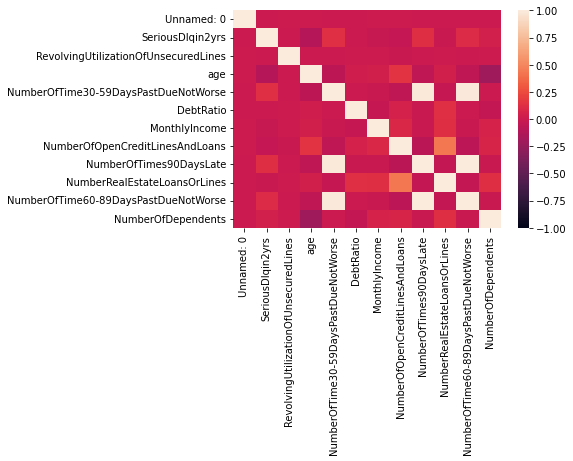

In [6]:
sns.heatmap(df_train.corr(),vmin=-1,vmax=1)

In [7]:
df_train.corr()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
Unnamed: 0,1.000000,-0.000201,0.003024,0.006790,-0.001261,-0.005507,0.002799,0.003607,-0.001722,-0.002131,-0.001479,-0.001258
SeriousDlqin2yrs,-0.000201,1.000000,-0.002869,-0.116339,0.127677,-0.007198,-0.018784,-0.031360,0.119131,-0.007904,0.104477,0.043064
RevolvingUtilizationOfUnsecuredLines,0.003024,-0.002869,1.000000,-0.005856,-0.001474,0.004366,0.004095,-0.013188,-0.001166,0.004312,-0.001200,0.005385
age,0.006790,-0.116339,-0.005856,1.000000,-0.063670,0.025618,0.034510,0.147729,-0.061688,0.032466,-0.057723,-0.214740
NumberOfTime30-59DaysPastDueNotWorse,-0.001261,0.127677,-0.001474,-0.063670,1.000000,-0.006845,-0.009610,-0.056065,0.983877,-0.031000,0.987290,-0.002152
DebtRatio,-0.005507,-0.007198,0.004366,0.025618,-0.006845,1.000000,-0.026307,0.050581,-0.008635,0.125974,-0.007765,-0.043822
MonthlyIncome,0.002799,-0.018784,0.004095,0.034510,-0.009610,-0.026307,1.000000,0.087361,-0.012096,0.117893,-0.010509,0.058447
NumberOfOpenCreditLinesAndLoans,0.003607,-0.031360,-0.013188,0.147729,-0.056065,0.050581,0.087361,1.000000,-0.080807,0.434723,-0.071917,0.064264
NumberOfTimes90DaysLate,-0.001722,0.119131,-0.001166,-0.061688,0.983877,-0.008635,-0.012096,-0.080807,1.000000,-0.045679,0.992917,-0.009487
NumberRealEstateLoansOrLines,-0.002131,-0.007904,0.004312,0.032466,-0.031000,0.125974,0.117893,0.434723,-0.045679,1.000000,-0.040096,0.124587


Taking into account that only about 3% of NumberOfDependents are null and that the absence of values in this situation usually could indicate the lack of dependents, it seems reasonable to complete the null values with zero.

A similar approach could be followed for the MonthlyIncome, as it is possible that people with no income could have had this value set to zero. Other alternative could be drop the lines, but considering we are talking about 30 thousands lines, we could lose revelant information in this process.

In [8]:
 #Preprocessing pipeline
 #RobustScaler was applied considering that data exploratory analysis showed high standard deviation values   
 preprocessing = Pipeline([
    ('Fill_na', SimpleImputer(strategy='constant',fill_value=0)),
    ('Outlier_Scaling', RobustScaler())
  ])

## Training the model
### Define a list of binary classification models considered

**Random Forest** and a **Logistic Regression model** were the ones chosen as a learning exercise.

In [9]:
#Parameter setting for the models
random_forest = RandomForestClassifier(n_estimators=100, max_features='auto', bootstrap=True, max_samples=1/3)
log_reg = LogisticRegression(solver= 'liblinear', C=100, random_state=42)

#Define a model list to iterate
model_list = [random_forest,log_reg]

The main idea was to create a standard pipeline process in which each model will be pre-processed (for scaling, treatment of null values) and in sequence a parameter grid will be applied in order to determine the best parameter configuration, that is, the one who provides the highest score for each model.

The score chosen was the ROC curve which is the same used in the Kaggle competition what could provide a basis for comparison.

In cross validation a 5-fold cross validation was used.

In [10]:
#Iterate each model to define the best through cross validation
for model_classifier in model_list:

 #Pipeline with model
 pipe_model = Pipeline([
    ('preprocessing', preprocessing),
    ('classifier', model_classifier)
 ])

 #Parameter grid

 if model_classifier == random_forest:
     param_grid= [
    {'classifier__max_features' :['auto','log2',1/3, 2/3, 1],'classifier__max_samples': [1/3, 2/3, 1]}
             ]
 else: 
     param_grid = [
    {'classifier__C' :[10,100,1000],'classifier__class_weight': [None, 'dict', 'balanced']}
             ]

    
 #CV and grid search
 grid = GridSearchCV(estimator = pipe_model, param_grid = param_grid, cv = 5, scoring= 'roc_auc')

 #Define X and y
 X = df_train.drop(columns=['Unnamed: 0','SeriousDlqin2yrs'])
 y = df_train['SeriousDlqin2yrs']

 #Fit and score
 grid.fit(X, y)
 print(model_classifier)
 print('Best score: ', grid.best_score_)
 print('Best parameter: ',grid.best_params_)

RandomForestClassifier(max_samples=0.3333333333333333)
Best score:  0.8511747698750625
Best parameter:  {'classifier__max_features': 0.3333333333333333, 'classifier__max_samples': 0.3333333333333333}


C:\Users\barbo\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\barbo\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\barbo\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\barbo\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\barbo\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\barbo\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number 

LogisticRegression(C=100, random_state=42, solver='liblinear')
Best score:  0.7929150462961109
Best parameter:  {'classifier__C': 100, 'classifier__class_weight': 'balanced'}


*ps: The obtained convergence warnings are expected since the model may not converge for all combination of parameters on the grid.*

Now the model can be trained considering the best parameters obtained from last step. 

**Random Forest**
Best score:  0.85117
Best parameter:  {'classifier__max_features': 1/3, 'classifier__max_samples': 1/3}

**Logistic Regression**
LogisticRegression(C=1000, random_state=42, solver='liblinear')
Best score:  0.79291
Best parameter:  {'classifier__C': 100, 'classifier__class_weight': 'balanced'}

In [15]:
#Iterate each model with only the best parameter's configuration
for model_classifier in model_list:

 #Pipeline with model
 pipe_model = Pipeline([
    ('preprocessing', preprocessing),
    ('classifier', model_classifier)
 ])

 #Parameter grid

 if model_classifier == random_forest:
     param_grid= [
    {'classifier__max_features' :[1/3],'classifier__max_samples': [1/3]}
             ]
 else: 
     param_grid = [
    {'classifier__C' :[100],'classifier__class_weight': ['balanced']}
             ]

    
 #CV and grid search
 grid = GridSearchCV(estimator = pipe_model, param_grid = param_grid, cv = 5, scoring= 'roc_auc')

 #Define X and y - training dataset
 X = df_train.drop(columns=['Unnamed: 0','SeriousDlqin2yrs'])
 y = df_train['SeriousDlqin2yrs']

 #Define X_test and y_test - test dataset
 X_test = df_test.drop(columns=['Unnamed: 0','SeriousDlqin2yrs'])
 y_test = df_test['SeriousDlqin2yrs']

 #Fit and score
 grid.fit(X, y)
 
 #Class prediction classes for ROC curve plot   
 if model_classifier == random_forest:
      class_prediction_proba_rf = grid.predict_proba(X_test)
      class_prediction_rf = grid.predict(X_test)
 else:
      class_prediction_proba_lr = grid.predict_proba(X_test)
      class_prediction_lr = grid.predict(X_test)  
 #Print       
 print(model_classifier)
 print('Best parameter: ',grid.best_params_)

RandomForestClassifier(max_samples=0.3333333333333333)
Best parameter:  {'classifier__max_features': 0.3333333333333333, 'classifier__max_samples': 0.3333333333333333}
LogisticRegression(C=100, random_state=42, solver='liblinear')
Best parameter:  {'classifier__C': 100, 'classifier__class_weight': 'balanced'}


### For the models the relevant parameters are plotted, such as **Confusion Matrix** and **ROC curve**

In [16]:
def model_info(X_test, y_test, class_prediction, class_prediction_proba):
    #'''This function returns the critical information about the model'''
#pretty version of the above confusion matrix 
 conf_m = pd.DataFrame(confusion_matrix(y_test, class_prediction))
 conf_m.index = ['Actual Non-default (0)','Actual Default (1)']
 conf_m.columns = ['Predict Non-default (0)', 'Predict Default (1)']
 print(conf_m,'\n')
 tn, fp, fn, tp = conf_m.to_numpy().ravel()

#AUC roc score
 class_prediction_auc = roc_auc_score(y_true =y_test[:], y_score =class_prediction_proba[:,1])
 print(f'The auc scores of our model is {class_prediction_auc:.5f}.')

#Precision and recall
 score_precision = tp/(tp + fp)
 print(f'The precision of our model is {score_precision*100:.3f}%.')
 score_recall = tp/(tp + fn)
 print(f'The recall of our model is {score_recall*100:.3f}%.')

#LR model Roc Curve
 fpr, tpr, thresholds  = roc_curve(y_true =y_test[:], y_score =class_prediction_proba[:,1])
    
#No Skill model
 fpr_ns = np.linspace(0,1,num=len(fpr))
 trp_ns = fpr_ns

#Plotting ROC Curve
 plt.plot(fpr_ns, trp_ns, linestyle='dashed',label='No Skill')
 plt.plot(fpr, tpr,label='Lr model')
#Labels
 plt.title('ROC curve')
 plt.xlabel('False Positive Rate')
 plt.ylabel('True Positive Rate')
#Legend
 plt.legend()
 plt.show()

## Random Forest Model

                        Predict Non-default (0)  Predict Default (1)
Actual Non-default (0)                    27690                  280
Actual Default (1)                         1665                  365 

The auc scores of our model is 0.83926.
The precision of our model is 56.589%.
The recall of our model is 17.980%.


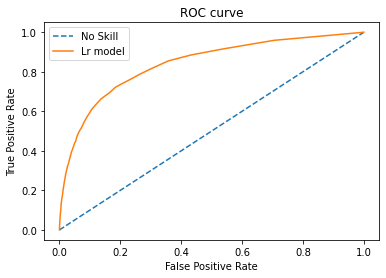

In [17]:
model_info(X_test, y_test, class_prediction_rf, class_prediction_proba_rf)

## Logistic Regression

                        Predict Non-default (0)  Predict Default (1)
Actual Non-default (0)                    21856                 6114
Actual Default (1)                          742                 1288 

The auc scores of our model is 0.78198.
The precision of our model is 17.401%.
The recall of our model is 63.448%.


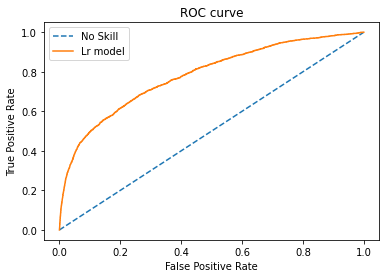

In [18]:
#For the sake of comparison, the Logistic Regression curve is plotted:
model_info(X_test, y_test, class_prediction_lr, class_prediction_proba_lr)

## Conclusions

1. From the data, one can see that low recall values were obtained, which means our model is still a bit insensitive to classify default-cases precisely. The "default data" and "non-default data" might look too similar to the model. This issue might has been also faced by others participants. For instance, the competition in Kaggle reunited 924 teams where the highest score obtained by the winner was 0.86955.<br>

2. The model implemented reached the ROC score of **0.83926 (96.5% of the maximum score in the competition)**.<br>

3. This relatively small difference shows that the model is robust considering the dataset provided.<br>

4. As suggestion, further parameter tunning could be considered.<br>

5. Certainly, credit risk analysis problems are open-ended fascinating problems of great importance to the financial industry.